# 02 Global Network Summaries

In [4]:
# ── Path-Fix for Imports ───────────────────────────────────────────────────
import sys
from pathlib import Path
# Prepend parent directory (repo root) to sys.path
sys.path.insert(0, str(Path().resolve().parent))

# ── Standard Imports ───────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.graph_utils import load_clean_df, build_unweighted_graph, build_weighted_graph

sns.set(style="whitegrid")

## Analysis goes here…

In [5]:
THRESHOLD  = 0
START_DATE = "2023-04-14"
END_DATE   = "2023-05-31"
USE_CACHE  = True

In [6]:
# Load Graph (Unweighted)
df = load_clean_df(
    threshold=THRESHOLD,
    start_date=START_DATE,
    end_date=END_DATE
)
G = build_unweighted_graph(
    df,
    threshold=THRESHOLD,
    start_date=START_DATE,
    end_date=END_DATE,
    use_cache=USE_CACHE
)

print(f"Total nodes: {G.number_of_nodes():,}")
print(f"Total edges: {G.number_of_edges():,}")
print(f"Density: {nx.density(G):.2e}")

Total nodes: 215,741
Total edges: 426,954
Density: 9.17e-06


In [8]:
# Connected Components

# Weakly connected components
wcc = list(nx.weakly_connected_components(G))
wcc_sizes = np.array([len(c) for c in wcc])

# Strongly connected components
scc = list(nx.strongly_connected_components(G))
scc_sizes = np.array([len(c) for c in scc])

print(f"# Weakly CC: {len(wcc)}; Giant WCC size: {wcc_sizes.max():,}")
print(f"# Strongly CC: {len(scc)}; Giant SCC size: {scc_sizes.max():,}")

# Extract giant WCC and SCC
giant_wcc = max(wcc, key=len)
core_scc = max(scc, key=len)


# Weakly CC: 8; Giant WCC size: 215,727
# Strongly CC: 97852; Giant SCC size: 117,717


In [11]:
# Approximate Giant WCC Metrics

import random
from tqdm import tqdm
from networkx.algorithms.approximation import diameter as approx_diameter

# Work on the undirected giant WCC
gG = G.subgraph(giant_wcc).copy().to_undirected()

# Sample BFS for average path length
sample_size = 500
seeds = random.sample(list(gG.nodes()), sample_size)

all_dists = []
for u in tqdm(seeds, desc="Sampling BFS"):
    all_dists.extend(nx.single_source_shortest_path_length(gG, u).values())

approx_avg = sum(all_dists) / len(all_dists)
print(f"Approx avg shortest path length (n={sample_size} seeds): {approx_avg:.2f}")

Sampling BFS: 100%|██████████| 500/500 [02:29<00:00,  3.34it/s]


Approx avg shortest path length (n=500 seeds): 3.20


In [12]:
# Approximate Diameter & Remaining Analyses
from networkx.algorithms.approximation import diameter as approx_diameter

# 1) Approximate diameter via double-sweep BFS
u0 = seeds[0]
lengths_u0 = nx.single_source_shortest_path_length(gG, u0)
u1 = max(lengths_u0.items(), key=lambda item: item[1])[0]
lengths_u1 = nx.single_source_shortest_path_length(gG, u1)
diam_est = max(lengths_u1.values())
print(f"Approx diameter (double-sweep): {diam_est}")

# 2) Try bounds if supported
try:
    low, high = approx_diameter(gG, usebounds=True)
    print(f"Diameter bounds: [{low}, {high}]")
except TypeError:
    diam_approx = approx_diameter(gG)
    print(f"Approx diameter (no bounds available): {diam_approx}")

Approx diameter (double-sweep): 43
Approx diameter (no bounds available): 43


Counter({2: 7, 215727: 1})


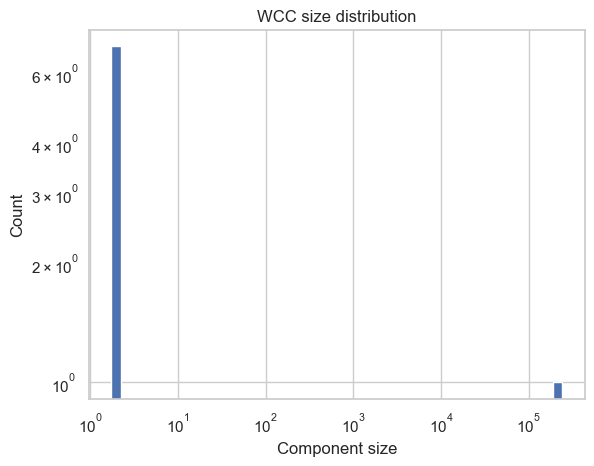

In [14]:
# 3) Component Size Distributions

# Count exact sizes
from collections import Counter
wcc_counter = Counter(map(len, wcc))
print(wcc_counter)
# e.g. Counter({1: 7, 215727: 1})

# Bar chart for those two values
sizes, counts = zip(*sorted(wcc_counter.items()))
plt.bar(sizes, counts, width=[0.5, 50000])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Component size')
plt.ylabel('Count')
plt.title('WCC size distribution')
plt.show()


In [16]:
# Fast Bow-Tie Decomposition via Multi-Source BFS
from collections import deque

def multi_source_reachable(G, sources, forward=True):
    """
    Return the set of nodes reachable from any node in 'sources' via directed edges.
    If forward=False, uses G.reverse() instead.
    """
    if not forward:
        G = G.reverse(copy=False)
    visited = set(sources)
    queue = deque(sources)
    while queue:
        u = queue.popleft()
        for v in G.successors(u):
            if v not in visited:
                visited.add(v)
                queue.append(v)
    return visited

# we already have:
#   giant_wcc = max(nx.weakly_connected_components(G), key=len)
#   core_scc   = max(nx.strongly_connected_components(G),    key=len)

# Compute IN (nodes that can reach the SCC) and OUT (nodes the SCC can reach)
full_in  = multi_source_reachable(G, core_scc, forward=False)
full_out = multi_source_reachable(G, core_scc, forward=True)

IN       = full_in  - core_scc
OUT      = full_out - core_scc
TUBES    = full_in & full_out
TENDRILS = set(giant_wcc) - core_scc - IN - OUT - TUBES

bowtie = {
    'IN':       len(IN),
    'SCC':      len(core_scc),
    'OUT':      len(OUT),
    'TUBES':    len(TUBES),
    'TENDRILS': len(TENDRILS)
}
pd.DataFrame.from_dict(bowtie, orient='index', columns=['size'])


,size
IN,49
SCC,117717
OUT,97954
TUBES,117717
TENDRILS,7


## Summary of Global Network Structure

**1. Basic Network Metrics**  
- **Nodes:** 215 741  
- **Edges:** 426 954  
- **Density:** 9.17 × 10⁻⁶ (ultra‐sparse)  

**2. Connected Components**  
- **Weakly Connected:** 8 total components  
  - **Giant WCC:** 215 727 nodes (> 99.99 %)  
- **Strongly Connected:** 97 852 total components  
  - **Giant SCC:** 117 717 nodes (~ 55 %)  

**3. Small‐World Properties**  
- **Approx. Avg. Shortest Path:** 3.20 hops (sampled over 500 seeds)  
- **Approx. Diameter:** 43 (double‐sweep BFS)  

**4. Component‐Size Distributions**  
- **WCC:** one massive bin at ~2×10⁵ nodes and a few singletons  
- **SCC:** one core at ~1.2×10⁵ nodes plus many singletons  

**5. Bow-Tie Decomposition**

| Region     | Size    | What it Means                                                                                       |
|:-----------|--------:|:----------------------------------------------------------------------------------------------------|
| **IN**     | 49      | Wallets that **feed into** the core but never receive back (initial liquidity sources/bridges).     |
| **SCC**    | 117 717 | The **strongly‐connected core** (exchanges, DEX routers)—every node can reach every other.          |
| **OUT**    | 97 954  | Wallets that **receive from** the core but never send back (speculators cashing out).               |
| **TUBES**  | 117 717 | Nodes both in IN and OUT – here exactly the SCC itself (no extra tube nodes beyond the core).        |
| **TENDRILS** | 7     | Fringe wallets in the giant WCC that are neither feeding in nor out—tiny isolated periphery.        |

---

### 🔍 Interpretation

- The PEPE network is dominated by one giant weak component and a massive reciprocal core.  
- Small‐world behavior (avg. path ≈ 3, diameter ≈ 43) emerges despite extreme sparsity.  
- A handful of “feeder” addresses kick liquidity into a large, highly interwoven exchange/DEX core.  
- That core then disperses tokens out to nearly 100 k speculator wallets, with very few alternate pathways.  
- The minimal tendrils highlight how almost every wallet is either in the core, feeding in, or feeding out—underscoring the classic bow-tie shape in a meme‐coin frenzy.
